In [457]:
from scipy.stats import binom

DAY = 113
MONTH = 3410
YEAR = 41500
D = 13 # 11 bit network radius + 4 equal weighted nodes per bin
p = 1 / (2 << (D-1)) # probability of winning on a given epoch

NNODES = 16

REWARD_BZZ = 40
BZZUSD = 0.28

REWARD = REWARD_BZZ * BZZUSD

In [458]:
# AWS prices for 16 nodes estimate
# https://aws.amazon.com/ec2/pricing/on-demand/

EC2_HOUR = NNODES * 0.0672 / 16 # t4g.large - assume this can run 16 nodes
#M6I_4XLARGE_HOUR = 0.768
EC2_EPOCH = EC2_HOUR * 5 * 152 / 3600
EC2_MONTH = EC2_HOUR * 24 * 30
print(f"Compute cost per month: {EC2_MONTH:0.2f}")

# https://aws.amazon.com/ebs/pricing/

EBS_GB_MONTH = 0.08
EBS_MONTH = EBS_GB_MONTH * 16 * NNODES
EBS_EPOCH = EBS_MONTH * 5 * 152 / (30*86400)
print(f"Storage cost per month: {EBS_MONTH:0.2f}")

COST_EPOCH = EC2_EPOCH + EBS_EPOCH
COST_MONTH = EC2_MONTH + EBS_MONTH
print(f"Total cost per month:   {EC2_MONTH+EBS_MONTH:0.2f}")


INIT = COST_MONTH * 2 # enough cash reserves for 2 months of costs

Compute cost per month: 48.38
Storage cost per month: 20.48
Total cost per month:   68.86


In [459]:
print(f"Expected monthly revenue: {MONTH * REWARD * p * NNODES:.02f}")

Expected monthly revenue: 74.59


## Value at risk, dry spells

In [460]:
print(f"Prob(no rewards in a month |  1 node): {binom.pmf(0, MONTH, p):.03f}")
print(f"Prob(no rewards in a year  |  1 node): {binom.pmf(0, YEAR, p):.03f}")
print("")
print(f"Prob(no rewards in a month | 16 nodes): {binom.pmf(0, MONTH, 16*p):.03f}")
print(f"Prob(no rewards in a year  | 16 nodes): {binom.pmf(0, YEAR, 16*p):.03f}")

Prob(no rewards in a month |  1 node): 0.659
Prob(no rewards in a year  |  1 node): 0.006

Prob(no rewards in a month | 16 nodes): 0.001
Prob(no rewards in a year  | 16 nodes): 0.000


In [461]:
for d in range(0,10):
    n = (2<<d) // 2
    nwins = int(binom.ppf(0.05, MONTH, n*p))
    print(f"Monthly revenue @5% with {n} nodes: {nwins * REWARD:0.2f}")
    
print("")

for d in range(0,10):
    n = (2<<d) // 2
    nwins = int(binom.ppf(0.01, MONTH, n*p))
    print(f"Monthly revenue @1% with {n} nodes: {nwins*REWARD:0.2f}")

Monthly revenue @5% with 1 nodes: 0.00
Monthly revenue @5% with 2 nodes: 0.00
Monthly revenue @5% with 4 nodes: 0.00
Monthly revenue @5% with 8 nodes: 11.20
Monthly revenue @5% with 16 nodes: 33.60
Monthly revenue @5% with 32 nodes: 89.60
Monthly revenue @5% with 64 nodes: 201.60
Monthly revenue @5% with 128 nodes: 470.40
Monthly revenue @5% with 256 nodes: 1008.00
Monthly revenue @5% with 512 nodes: 2128.00

Monthly revenue @1% with 1 nodes: 0.00
Monthly revenue @1% with 2 nodes: 0.00
Monthly revenue @1% with 4 nodes: 0.00
Monthly revenue @1% with 8 nodes: 0.00
Monthly revenue @1% with 16 nodes: 22.40
Monthly revenue @1% with 32 nodes: 67.20
Monthly revenue @1% with 64 nodes: 168.00
Monthly revenue @1% with 128 nodes: 414.40
Monthly revenue @1% with 256 nodes: 940.80
Monthly revenue @1% with 512 nodes: 2027.20


In [462]:
for d in range(0,10):
    n = (2<<d) // 2
    nwins = int(binom.ppf(0.05, MONTH, n*p))
    cost = n * COST_MONTH / NNODES
    print(f"Monthly VaR@5% with {n} nodes: {INIT + nwins * REWARD - cost:0.2f}")
    
print("")

for d in range(0,10):
    n = (2<<d) // 2
    nwins = int(binom.ppf(0.01, MONTH, n*p))
    cost = n * COST_MONTH / NNODES
    print(f"Monthly VaR@1% with {n} nodes: {INIT + nwins*REWARD - cost:0.2f}")

Monthly VaR@5% with 1 nodes: 133.42
Monthly VaR@5% with 2 nodes: 129.12
Monthly VaR@5% with 4 nodes: 120.51
Monthly VaR@5% with 8 nodes: 114.50
Monthly VaR@5% with 16 nodes: 102.46
Monthly VaR@5% with 32 nodes: 89.60
Monthly VaR@5% with 64 nodes: 63.87
Monthly VaR@5% with 128 nodes: 57.22
Monthly VaR@5% with 256 nodes: 43.90
Monthly VaR@5% with 512 nodes: 62.08

Monthly VaR@1% with 1 nodes: 133.42
Monthly VaR@1% with 2 nodes: 129.12
Monthly VaR@1% with 4 nodes: 120.51
Monthly VaR@1% with 8 nodes: 103.30
Monthly VaR@1% with 16 nodes: 91.26
Monthly VaR@1% with 32 nodes: 67.20
Monthly VaR@1% with 64 nodes: 30.27
Monthly VaR@1% with 128 nodes: 1.22
Monthly VaR@1% with 256 nodes: -23.30
Monthly VaR@1% with 512 nodes: -38.72


In [463]:
for d in range(0,10):
    n = (2<<d) // 2
    nwins = int(binom.ppf(0.05, YEAR, n/(2<<12)))
    cost = n * COST_MONTH / NNODES
    print(f"Annual VaR@5% with {n} nodes: {INIT + nwins * REWARD - cost*12:0.2f}")
    
print("")

for d in range(0,10):
    n = (2<<d) // 2
    nwins = int(binom.ppf(0.01, YEAR, n/(2<<12)))
    cost = n * COST_MONTH / NNODES
    print(f"Annual VaR@1% with {n} nodes: {INIT + nwins*REWARD - cost*12:0.2f}")

Annual VaR@5% with 1 nodes: 108.48
Annual VaR@5% with 2 nodes: 90.43
Annual VaR@5% with 4 nodes: 76.74
Annual VaR@5% with 8 nodes: 60.54
Annual VaR@5% with 16 nodes: 61.76
Annual VaR@5% with 32 nodes: 64.19
Annual VaR@5% with 64 nodes: 136.26
Annual VaR@5% with 128 nodes: 325.18
Annual VaR@5% with 256 nodes: 792.64
Annual VaR@5% with 512 nodes: 1839.55

Annual VaR@1% with 1 nodes: 97.28
Annual VaR@1% with 2 nodes: 79.23
Annual VaR@1% with 4 nodes: 54.34
Annual VaR@1% with 8 nodes: 26.94
Annual VaR@1% with 16 nodes: -5.44
Annual VaR@1% with 32 nodes: -25.41
Annual VaR@1% with 64 nodes: 1.86
Annual VaR@1% with 128 nodes: 134.78
Annual VaR@1% with 256 nodes: 523.84
Annual VaR@1% with 512 nodes: 1469.95


## Hitting time distribution

In [472]:
# %%timeit
# 5.28 ms ± 619 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

ticks = np.arange(1,10*YEAR)
hit_prob = np.zeros(10*YEAR-1)

breakeven = (ticks-(INIT//COST_EPOCH)) / (REWARD//COST_EPOCH) # number of wins needed to exactly break even at time t
breakeven_prob = binom.pmf(breakeven, ticks, p*NNODES) # probability to exactly break even at epoch t

hit_prob = INIT * breakeven_prob / ticks # use hitting time theorem

# In practice, the following seems to approximate P(ruin in finite time) to 4 d.p.
# i.e. increasing the time span doesn't change the result
print(f"P(ruin in 10 years) = {hit_prob.sum():.04f}")

P(ruin in 10 years) = 0.0028


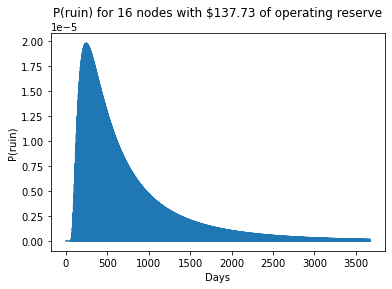

In [473]:
plt.plot(ticks / 113, hit_prob)
ax = plt.gca()
ax.set_xlabel("Days")
ax.set_ylabel("P(ruin)")
ax.set_title(f"P(ruin) for {NNODES} nodes with ${INIT:.02f} of operating reserve")
plt.show()